In [1]:
import numpy as np
import itertools as it
from scipy.special import gamma
from scipy.special import multigammaln

def BHC_vanilla(data, likelihood, alpha):
    """
    Bayesian hierarchical clustering algorithm, direct implementation from paper.
    
    Parameters
    ----------
    data : 2D numpy array
        Data with rows as observations and columns as variables.
    likelihood : function
        Function that returns the marginal likelihood of data in BHC model.
    alpha : float
        Concentration parameter in model.
        
    Returns
    -------
    T_record : list(list(int))
        Cluster structure in each iteration.
    rk_record : list(float)
        Merge probability (rk) in each iteration.
    """
    
    n = data.shape[0]
    p = data.shape[1]
    c = n
    D = dict((index, Node(obs.reshape(-1, p), alpha)) for index, obs in enumerate(data))
    T = list(range(n))
    T_record = list(T)
    rk_record = [1]
    
    while c > 1:
        max_rk = float('-Inf')
        node_merge = None
        left_merge = -1
        right_merge = -1
        
        for i, j in it.combinations(D.keys(), 2):
            Di = D[i]
            Dj = D[j]
            Dk = Node.merge_node(Di, Dj)
            
            likelihood_i = likelihood(Di.data)
            likelihood_j = likelihood(Dj.data)
            likelihood_k = likelihood(Dk.data)
            
            pi_k = Dk.pi_k

            rk = (pi_k * likelihood_k) / (pi_k * likelihood_k + (1 - pi_k) * likelihood_i * likelihood_j)

            if rk > max_rk:
                max_rk = rk
                node_merge = Dk
                left_merge = i
                right_merge = j
        
        #delete merged nodes and store new node
        del D[right_merge]
        D[left_merge] = node_merge

        #store the current tree structure and value of rk
        for item_index, node_index in enumerate(T):
            if node_index == right_merge:
                T[item_index] = left_merge
        T_record.append(list(T))
        rk_record.append(max_rk)
        
        c -= 1
        
    return T_record, rk_record
        

class Node(object):
    """
    Node class used in Bayesian hierarchical clustering algorithm. Main purpose is to store values of dk and pi_k for each node.
    
    Attributes
    ----------
    data : 2D numpy array
        Data with rows as observations and columns as variables.
    dk : float
        Some kind of number for computing probabilities
    pi_k : float
        For to compute merge probability
        
    Methods
    -------
    __init__(self, data, likelihood, alpha = 1)
        Instantiation operation.
    merge_node(cls, node1, node2, alpha = 1)
        Method that merges two Nodes into one new Node and return the new Node.
    """
    
    def __init__(self, data, alpha = 1, dk = 1, pi_k = 1):
        """
        Instantiation operation.
        
        Parameters
        ----------
        data : 2D numpy array
            Data with rows as observations and columns as variables.
        likelihood : function
            Function that returns the likelihood of data, sampling distribution in BHC model.
        alpha : float
            Concentration parameter in model.
        log_dk : float
            Cached probability variable. Do not define if the node is a leaf.
        log_pi : float
            Cached probability variable. Do not define if the node is a leaf.
        """
        
        #initialized according to paper
        self.data = data
        self.dk = dk
        self.pi_k = pi_k

    @classmethod
    def merge_node(cls, node1, node2, alpha = 1):
        """
        Merge two Nodes into one new Node and return the new Node.
        
        Parameters
        ----------
        node1 : Node
            First Node.
        node2 : Node
            Second Node.
        """

        data = np.vstack((node1.data, node2.data))

        nk = data.shape[0]
        dk = alpha * gamma(nk) + node1.dk * node2.dk
        pi_k = alpha * gamma(nk) / dk

        return cls(data, alpha, dk, pi_k)

In [2]:
from scipy.stats import multivariate_normal
def Multinorm_post_marginal_likelihood(mu_0, kappa_0, nu_0, Psi_0):
    """
    Returns a function that computes the marginal likelihood 
    for a Normal-inverse-Wishart model with specifies data and prior parameters.
    """
    
    def marginal_likelihood(data):
        n = data.shape[0]
        p = data.shape[1]
        xbar = data.mean(axis = 0)
    
        #update posterior parameters
        kappa_n = kappa_0 + n
        mu_n = (kappa_0 * mu_0 + n * xbar) / kappa_n
        nu_n = nu_0 + n
    
        if (n == 1):
            C = np.zeros((p, p))
        else:
            C = (n - 1) * np.cov(data.T)
        Psi_n = Psi_0 + C + ((n * kappa_0) / (kappa_n)) * np.dot((xbar - mu_0).reshape(-1, p).T, (xbar - mu_0).reshape(-1, p))
    
        return (1 / np.pi**(n * p / 2)) * (np.exp(multigammaln(nu_n / 2, p)) / np.exp(multigammaln(nu_0 / 2, p))) * (np.linalg.det(Psi_0)**(nu_0 / 2) / np.linalg.det(Psi_n)**(nu_n / 2)) * (kappa_0 / kappa_n)**(p / 2)

    return marginal_likelihood

In [7]:
n = 10
y1 = np.random.multivariate_normal([0, 0], np.eye(2) * 0.1, n)
y2 = np.random.multivariate_normal([5, 0], np.eye(2) * 0.3, n)
y3 = np.random.multivariate_normal([0, 5], np.eye(2) * 0.5, n)
y4 = np.random.multivariate_normal([-5, 5], np.eye(2) * 0.7, n)
y5 = np.random.multivariate_normal([0, -5], np.eye(2) * 0.9, n)
data = np.vstack((y1, y2, y3, y4, y5))

likelihood = Multinorm_post_marginal_likelihood(mu_0 = np.zeros(2), kappa_0 = 1, nu_0 = 2 + 1, Psi_0 = np.eye(2))

clusters, rks = BHC_vanilla(data, likelihood, 1)
clust_n = next(x for x, val in enumerate(rks) if val < 0.5)

In [8]:
clust_n = data.shape[0] - next(x for x, val in enumerate(rks) if val < 0.5) + 1
clust_n

5

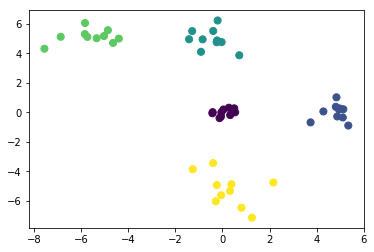

In [9]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c = clusters[-clust_n], s = 50)
plt.show()

In [10]:
rks

[1,
 0.9942466241723537,
 0.9963153518689523,
 0.9975249329929716,
 0.9987930074538307,
 0.9991894471371614,
 0.9989651500861012,
 0.9993283215371829,
 0.9960444621940412,
 0.9905026484611273,
 0.9864284083586652,
 0.9928904765200508,
 0.9935569857306848,
 0.9954788093875282,
 0.9972106978281808,
 0.9909280198357628,
 0.9862300601044328,
 0.9892569689371085,
 0.9942478461170154,
 0.9967472571761106,
 0.9951590983453622,
 0.9938068919329623,
 0.9964148905168108,
 0.9965705961587689,
 0.9842859478083492,
 0.9811253036176756,
 0.9892455325472198,
 0.9942095535709684,
 0.9959091103741664,
 0.996571081547893,
 0.9979604073111642,
 0.993018703276128,
 0.9951569802358979,
 0.9934557558016615,
 0.9729555809063485,
 0.9698825973148286,
 0.9507238456511514,
 0.678962532280312,
 0.7178034033850947,
 0.8230409425715116,
 0.9012891959057443,
 0.921096528176274,
 0.9326871140987633,
 0.9371298945775134,
 0.9483580709940856,
 0.960334335369218,
 0.3312403859819779,
 5.643765122678733e-05,
 5.88239304

In [4]:
clusters

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  36,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  32,
  37,
  32,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  

In [12]:
import pandas as pd
glass = pd.read_csv("data/glass.data", index_col=0, header=None)
iris = pd.read_csv("data/iris.data", header=None)
glass = np.asarray(glass)

In [ ]:
likelihood = Multinorm_post_marginal_likelihood(mu_0 = np.zeros(10), kappa_0 = 1, nu_0 = 10 + 1, Psi_0 = np.eye(10))
BHC_glass = BHC_vanilla(glass, likelihood, 1)

C:\Users\erics\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
C:\Users\erics\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


In [14]:
glass.shape

(214, 10)

In [ ]:
data = glass
mu_0 = np.zeros(2)
kappa_0 = 1
nu_0 = 2 + 1
Psi_0 = np.eye(2)

n = data.shape[0]
p = data.shape[1]
xbar = data.mean(axis = 0)
    
#update posterior parameters
kappa_n = kappa_0 + n
mu_n = (kappa_0 * mu_0 + n * xbar) / kappa_n
nu_n = nu_0 + n